In [13]:
!pip install langgraph langchain_groq
!pip install python-dotenv

In [14]:
#Importing libraries
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_groq import ChatGroq
from IPython.display import display, Image
from dotenv import load_dotenv
import os

In [17]:
from google.colab import files
uploaded=files.upload()

Saving .env to .env


In [18]:
load_dotenv(dotenv_path=".env")  # Explicit path
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key:
    print("Groq API Key loaded successfully!")
else:
    print("Error: Groq API Key not found. Check your .env file.")

Groq API Key loaded successfully!


In [19]:
#Creating the state class
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [21]:
#Defining the llm
llm = ChatGroq(
    temperature = 0,
    groq_api_key = groq_api_key,
    model_name = "llama-3.3-70b-versatile"
)

#testing the model
result = llm.invoke("what is a cow")
result.content

'A cow is a large, domesticated mammal that belongs to the family Bovidae. Cows are female cattle, typically raised for their milk, meat, and hides. They are one of the most common and widespread domesticated animals in the world.\n\nHere are some key characteristics of cows:\n\n1. **Physical appearance**: Cows are large, hooved, herbivorous mammals with a distinctive body shape. They have a broad head, a long tail, and a coat of hair that can vary in color and pattern.\n2. **Diet**: Cows are ruminants, which means they have a four-chambered stomach that allows them to digest plant-based foods, such as grasses, hay, and grains.\n3. **Reproduction**: Cows give birth to calves after a gestation period of about 280 days. They typically have one calf per year, although some breeds may have twins.\n4. **Milk production**: Cows are known for their milk, which is rich in nutrients and is often consumed by humans. Dairy cows are bred specifically for their milk production, and they can produce

Defining the node functions

In [22]:
#categorizing function
def categorize(state : State) -> State:
     "Technical, Billing, General"
     prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
      "Technical, Billing, General. Query: {query}"
     )
     chain = prompt | llm
     category = chain.invoke({"query" : state['query']}).content
     return {"category": category}

In [23]:
# analyzing sentiment function
def analyze_sentiment(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state['query']}).content  # Capture sentiment
    return {"sentiment": sentiment}  # Return sentiment instead of category

In [24]:
#handle technical function
def handle_technical(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query : {query}"

    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [25]:
#handling billing function
def handle_billing(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query : {query}"

    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [26]:
#handle general
def handle_general(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query : {query}"

    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [27]:
#escalate the situation
def escalate(state : State) -> State:
    return{"response" : "This query has been escalate to a human agent due to its negative sentiment"}

In [28]:
# handling the routing function
def route_query(state: State) -> State:
    if state['sentiment'] == 'Negative':
        return "escalate"
    elif state['category'] == 'Technical':
        return "handle_technical"
    elif state['category'] == 'Billing':
        return "handle_billing"
    else:
        return "handle_general"

Create and configure graphs

In [29]:

#crafting the workflow
workflow = StateGraph(State)
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

In [30]:
#adding edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges("analyze_sentiment",
route_query,{
    "handle_technical" : "handle_technical",
    "handle_billing": "handle_billing",
    "handle_general" : "handle_general",
    "escalate": "escalate"
})
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

In [32]:
#adding the entry point
workflow.set_entry_point("categorize")

#compile the workflow
app = workflow.compile()

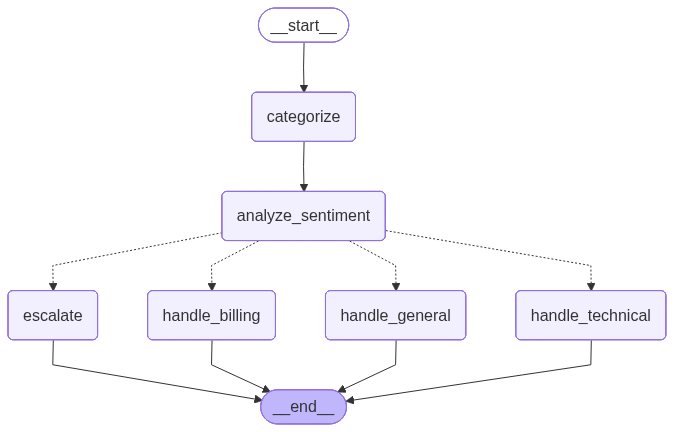

In [33]:
#vizualise the graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )

))

Running the program and testing output

In [35]:
#Function to run customer support
def run_customer_support(query: str) -> dict:
    result = app.invoke({"query": query})
    return {
        "category": result['category'],
        "sentiment": result['sentiment'],
        "response": result['response'],
    }

In [36]:
#testing the output
query = "My internet keeps lagging especially during the afternoon hours, Can you help me?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet keeps lagging especially during the afternoon hours, Can you help me?
Category: I would categorize this customer query as: **Technical**

The query is related to a technical issue with the customer's internet service, specifically a problem with lagging, which is a common technical issue that requires troubleshooting or technical support.
Sentiment: Neutral. 

The customer is reporting an issue with their internet, which could be perceived as negative, but they are also asking for help in a polite manner, which suggests a neutral tone. There is no aggressive language or emotional tone, indicating that the customer is simply seeking assistance to resolve the problem.
Response: I'd be happy to help you troubleshoot the issue with your internet lagging, especially during the afternoon hours.

To better understand the problem, can you please tell me a bit more about your internet setup and the issues you're experiencing? For example:

* What type of internet connection d

In [37]:
#testing the output
query = "What is your age?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: What is your age?
Category: I would categorize the customer query "What is your age?" as General. This query does not relate to a specific technical issue or billing concern, but rather is a more casual and general question.
Sentiment: Neutral. The query is a simple question and does not express any emotion or opinion, so it is neither positive nor negative.
Response: I'm just an artificial intelligence language model, so I don't have a physical body or personal characteristics like age. I exist solely to assist and provide information to users, and I don't have a personal history or identity. I'm here to help answer your questions and provide support to the best of my abilities, though! Is there anything else I can help with?




In [40]:
# Create the Gradio interface

import gradio as gr

def gradio_interface(query: str):
    result = run_customer_support(query)
    return (
        f"**Category:** {result['category']}\n\n"
        f"**Sentiment:** {result['sentiment']}\n\n"
        f"**Response:** {result['response']}"
    )

In [41]:
# Build the Gradio app
gui = gr.Interface(
    fn=gradio_interface,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=gr.Markdown(),
    title="Customer Support Assistant",
    description="Provide a query and receive a categorized response. The system analyzes sentiment and routes to the appropriate support channel.",
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


theme_schema%400.0.1.json: 0.00B [00:00, ?B/s]

In [42]:
# Launch the app
if __name__ == "__main__":
    gui.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8e82d960ed4dd3d7db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
